# Analysis of the Stack Overflow Developer Survey Dataset

## Focus of the Analysis

I want to analyze what contibutest to developers Job Satisfaction

In [1]:
# import python modules

import pandas as pd
import os
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt 

In [2]:
# load the dataset

df = pd.read_csv(os.path.join('data','survey_results_public.csv'))

df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Understand the Data


<AxesSubplot:>

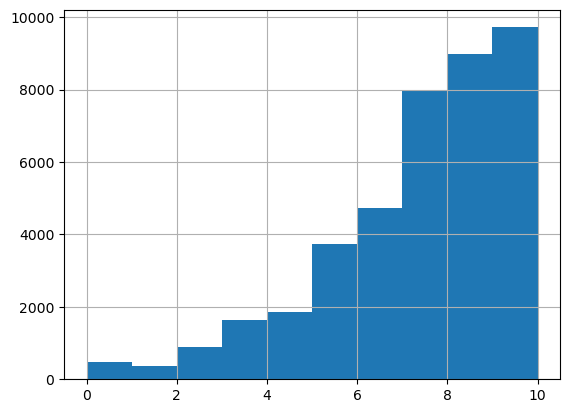

In [3]:
# plot HoursPerWeek as histogram
df['JobSatisfaction'].hist()

In [4]:
print(df['EmploymentStatus'].unique())

['Not employed, and not looking for work' 'Employed part-time'
 'Employed full-time'
 'Independent contractor, freelancer, or self-employed'
 'Not employed, but looking for work' 'I prefer not to say' 'Retired']


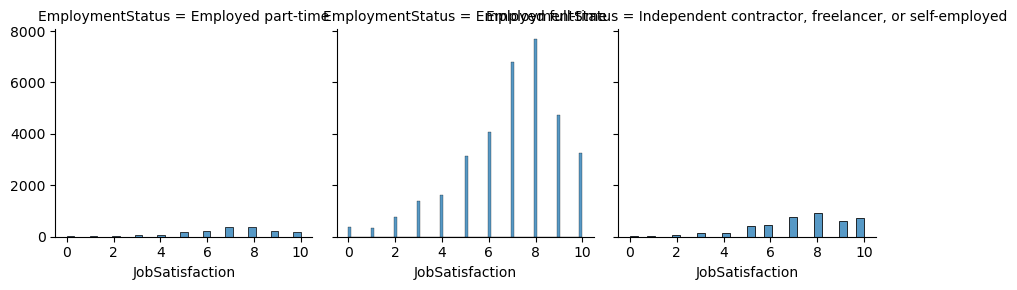

In [5]:
# lets look, how the job satisfaction varies with employment status
relevant_employment_status = ['Employed full-time','Employed part-time','Independent contractor, freelancer, or self-employed']

g = sns.FacetGrid(df[df['EmploymentStatus'].isin(relevant_employment_status)], col="EmploymentStatus")
g.map(sns.histplot, "JobSatisfaction")

In [6]:
print(df['Professional'].unique())

['Student' 'Professional developer'
 'Professional non-developer who sometimes writes code'
 'Used to be a professional developer' 'None of these']


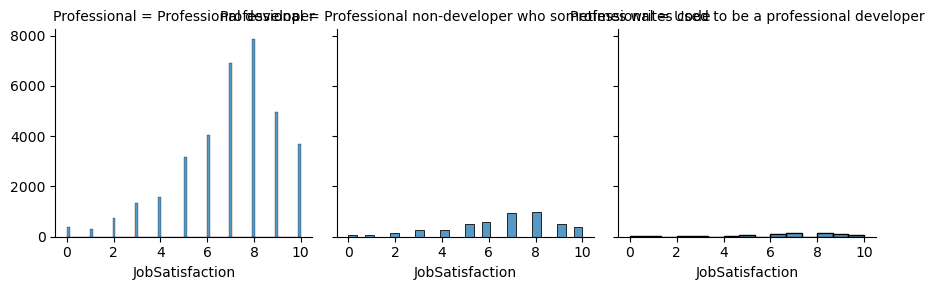

In [7]:
# lets look how Job Satisfaction varies with profession
relevant_professional =['Professional developer','Professional non-developer who sometimes writes code','Used to be a professional developer']

g = sns.FacetGrid(df[df['Professional'].isin(relevant_professional)], col="Professional")
g.map(sns.histplot, "JobSatisfaction")

## Prepare the Data

### Filter for the group of people I want to take a closer look at

As I want to analyze work hours of developers, I want to limit my dataset to the answers of respondends who are employed. To make it comparable, I choose only full-time employed respondents.

Also I only want answers from professional developers because this is the subset of respondents I am interested in


In [8]:
# Limit the dataset to the answers from professional developers
dev_subset = df[(df['Professional'] == 'Professional developer') & (df['EmploymentStatus'].isin(relevant_employment_status))]

#check how much of the data are within this group of respondents
print('The proportion of working professional developers in the dataset is:',(len(dev_subset)/len(df)))

The proportion of working professional developers in the dataset is: 0.6873832503113325


The subset I choose, contains 69% of all respondents. I think this in big enough to get good results 

## Select the features 
I am interestes in how external factors, such as company size and type, and personal factors, such as job satisfaction, contribute to the working hours of the developers. Therefore, I am going to limit my dataset to the following columns: 

external factors: Country, HomeRemote, CompanySize, CompanyType, DeveloperType, YearsCodedJob, Salary

internal factors: ProgramHobby, CareerSatisfaction, JobSatisfaction, LastNewJob, WorkPayCare, KinshipDevelopers, FriendsDevelopers

In [9]:
y_col = ['JobSatisfaction']

external_factor_cols = ['Country','HomeRemote','CompanySize','CompanyType','DeveloperType','YearsCodedJob','Salary','EmploymentStatus']

internal_factor_cols =['ProgramHobby','CareerSatisfaction','LastNewJob','WorkPayCare','KinshipDevelopers','Gender']

cols_to_keep = y_col + external_factor_cols + internal_factor_cols

dev_subset = dev_subset[cols_to_keep]

print(dev_subset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35326 entries, 2 to 51390
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   JobSatisfaction     34955 non-null  float64
 1   Country             35326 non-null  object 
 2   HomeRemote          35281 non-null  object 
 3   CompanySize         31595 non-null  object 
 4   CompanyType         31528 non-null  object 
 5   DeveloperType       35317 non-null  object 
 6   YearsCodedJob       35051 non-null  object 
 7   Salary              12891 non-null  float64
 8   EmploymentStatus    35326 non-null  object 
 9   ProgramHobby        35326 non-null  object 
 10  CareerSatisfaction  35023 non-null  float64
 11  LastNewJob          23184 non-null  object 
 12  WorkPayCare         22102 non-null  object 
 13  KinshipDevelopers   21916 non-null  object 
 14  Gender              25599 non-null  object 
dtypes: float64(3), object(12)
memory usage: 4.3+ MB
None


The Columns JobSatisfaction, Salary and CareerSatiafaction are numerical columns. All other features are cathegorical. 

Also The Salary column has a lot of missing values that needs imputing. 

## How do we impute the missing values in the salary colum

I will try out two different ways of handling the missing values in the salary column: 

1) Droping the rows with missing values
2) Imputing with the median of the dataset
3) using a linear model to predict the missing Salary columns and then use this model to fill the columns

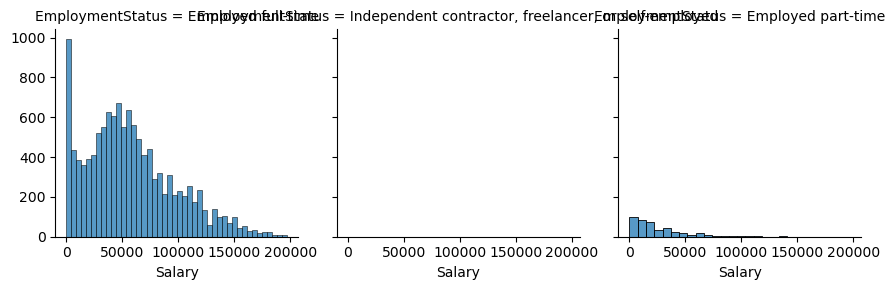

In [10]:
g = sns.FacetGrid(dev_subset, col="EmploymentStatus")
g.map(sns.histplot, "Salary")

This plot shows, that by dropping the rows with the missing salary information would lead to eliminating all the self-employed respondends form the dataset althought we do not even know jet, how much Salary contributes to the Job satisfaction. 

When we compare the salay plots for the Full-time and half-time employed respondends, we see, that using the mean is also not a good choice.

### preparing a dataset for each method to handle missing salary entrys

In [11]:
# Prearing a dataset where columns with mean salary are droppend
dev_subset_1 = dev_subset.dropna(subset=['Salary'])

dev_subset_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12891 entries, 2 to 51390
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   JobSatisfaction     12852 non-null  float64
 1   Country             12891 non-null  object 
 2   HomeRemote          12883 non-null  object 
 3   CompanySize         12880 non-null  object 
 4   CompanyType         12868 non-null  object 
 5   DeveloperType       12889 non-null  object 
 6   YearsCodedJob       12834 non-null  object 
 7   Salary              12891 non-null  float64
 8   EmploymentStatus    12891 non-null  object 
 9   ProgramHobby        12891 non-null  object 
 10  CareerSatisfaction  12861 non-null  float64
 11  LastNewJob          9078 non-null   object 
 12  WorkPayCare         8874 non-null   object 
 13  KinshipDevelopers   8817 non-null   object 
 14  Gender              11709 non-null  object 
dtypes: float64(3), object(12)
memory usage: 1.6+ MB


In [12]:
# preparing a subset where all missing salary information are filled with the median salary 
dev_subset_2 = dev_subset.copy()

dev_subset_2['Salary'].fillna(dev_subset_2['Salary'].median(), inplace=True)

dev_subset_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35326 entries, 2 to 51390
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   JobSatisfaction     34955 non-null  float64
 1   Country             35326 non-null  object 
 2   HomeRemote          35281 non-null  object 
 3   CompanySize         31595 non-null  object 
 4   CompanyType         31528 non-null  object 
 5   DeveloperType       35317 non-null  object 
 6   YearsCodedJob       35051 non-null  object 
 7   Salary              35326 non-null  float64
 8   EmploymentStatus    35326 non-null  object 
 9   ProgramHobby        35326 non-null  object 
 10  CareerSatisfaction  35023 non-null  float64
 11  LastNewJob          23184 non-null  object 
 12  WorkPayCare         22102 non-null  object 
 13  KinshipDevelopers   21916 non-null  object 
 14  Gender              25599 non-null  object 
dtypes: float64(3), object(12)
memory usage: 4.3+ MB


In [24]:
#functions for all the operations needed to perform a linear regression 

def prepare_df(df): 
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    
    for col in num_vars:
        
            df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy columns for the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    
    for var in  cat_vars:
        
        dummy_df = pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)
        
        df = pd.concat([df.drop(var, axis=1), dummy_df], axis=1)
    
    return df

def perform_linear_regression(X,y): 
    
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    
    lm_model = LinearRegression() # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test



In [25]:
#predict the missing salary entries

# Choose columns to predict the salary
subset_fit_salary = dev_subset.drop(columns='JobSatisfaction')
    
missing_salary_mask = subset_fit_salary['Salary'].notna()

# train the linear model on the subset with salaries

X_reg = prepare_df(subset_fit_salary[missing_salary_mask].drop(columns='Salary'))

y_reg = subset_fit_salary[missing_salary_mask]['Salary']

Res = perform_linear_regression(X_reg, y_reg)

print('test score:',Res[0])
print('train score:',Res[1])

print(Res[3].shape)

lm_model = Res[2]

test score: 0.6947336974101258
train score: 0.7661408478997023
(9023, 1174)


In [26]:
# get X that matches the subset with missing salary to fit salary

X_prepared = prepare_df(subset_fit_salary.drop(columns='Salary'))

#keep only columns that match the fitted data
X_prepared =X_prepared[Res[3].columns]

y_predict = lm_model.predict(X_prepared[~missing_salary_mask])


In [27]:
# fill the misssing Salaries with the predicted one

dev_subset_3_w_salary = dev_subset[missing_salary_mask].copy()

dev_subset_3_wo_salary = dev_subset[~missing_salary_mask].copy()

dev_subset_3_wo_salary.loc[:,'Salary'] =y_predict

dev_subset_3 = pd.concat([dev_subset_3_w_salary,dev_subset_3_wo_salary])

dev_subset_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35326 entries, 2 to 51389
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   JobSatisfaction     34955 non-null  float64
 1   Country             35326 non-null  object 
 2   HomeRemote          35281 non-null  object 
 3   CompanySize         31595 non-null  object 
 4   CompanyType         31528 non-null  object 
 5   DeveloperType       35317 non-null  object 
 6   YearsCodedJob       35051 non-null  object 
 7   Salary              35326 non-null  float64
 8   EmploymentStatus    35326 non-null  object 
 9   ProgramHobby        35326 non-null  object 
 10  CareerSatisfaction  35023 non-null  float64
 11  LastNewJob          23184 non-null  object 
 12  WorkPayCare         22102 non-null  object 
 13  KinshipDevelopers   21916 non-null  object 
 14  Gender              25599 non-null  object 
dtypes: float64(3), object(12)
memory usage: 4.3+ MB


1513

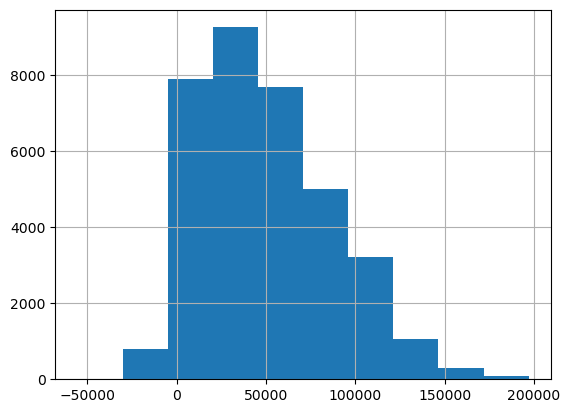

In [28]:
dev_subset_3['Salary'].hist()

#how many Salaries were predicted below 0
(y_predict <= 0).sum()

In [29]:
dev_subset['Salary'].min()

0.0

We can see, that the regression returned negative Salaries. I will replace them with a Salay of 0 as the original Dataset also contains Salaries of 0

In [30]:
dev_subset_3['Salary'][dev_subset_3['Salary'] < 0] = 0 

C:\Users\akg\AppData\Local\Temp\ipykernel_1524\2630548422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_subset_3['Salary'][dev_subset_3['Salary'] < 0] = 0


<AxesSubplot:>

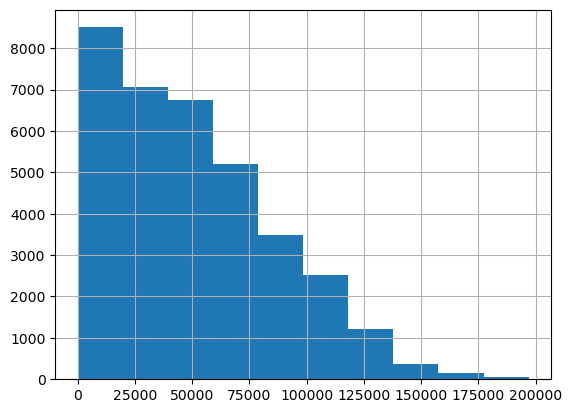

In [31]:
dev_subset_3['Salary'].hist()

## Linear regression 

### methon 1

In [34]:
# linear regression of dev_subset_1

dev_subset_1_for_fitting = dev_subset_1.dropna(subset=['JobSatisfaction'])

X_reg = prepare_df(dev_subset_1_for_fitting.drop(columns='JobSatisfaction'))

y_reg = dev_subset_1_for_fitting['JobSatisfaction']

Res = perform_linear_regression(X_reg, y_reg)

print('test score:',Res[0])
print('train score:',Res[1])

test score: 0.32819866185491164
train score: 0.47380365836500504


### metod 2

In [35]:
# linear regression of dev_subset_1

dev_subset_2_for_fitting = dev_subset_2.dropna(subset=['JobSatisfaction'])

X_reg = prepare_df(dev_subset_2_for_fitting.drop(columns='JobSatisfaction'))

y_reg = dev_subset_2_for_fitting['JobSatisfaction']

Res = perform_linear_regression(X_reg, y_reg)

print('test score:',Res[0])
print('train score:',Res[1])

test score: -1503078122197.187
train score: 0.47200324826807194


In [36]:
# linear regression of dev_subset_1

dev_subset_3_for_fitting = dev_subset_3.dropna(subset=['JobSatisfaction'])

X_reg = prepare_df(dev_subset_3_for_fitting.drop(columns='JobSatisfaction'))

y_reg = dev_subset_3_for_fitting['JobSatisfaction']

Res = perform_linear_regression(X_reg, y_reg)

print('test score:',Res[0])
print('train score:',Res[1])

test score: -81223265413.9408
train score: 0.46714913104441946
